## Enunciado

> Considere la información del proyecto cuya información aparece en la tabla adjunta:
> 1. ¿Cuál es la probabilidad de terminar el proyecto antes de 9 periodos?
> 2. Indique las actuaciones a llevar a cabo para reducir la duración del proyecto hasta 10 periodos con mínimo sobrecoste.
> 3. Nivele los recursos del proyecto.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, desviacion,  cur,  recursos, duracion_tope
     ('A',       '---  ',     3,        2,          5,       1,        1      ),
     ('B',       '---  ',     2,        1,          5,       1,        1      ),
     ('C',       'B    ',     4,        2,         25,       1,        2      ),
     ('D',       'A    ',     4,        0,          1,       1,        1      ),
     ('E',       'A    ',     2,        1,        -10,       2,        1      ),
     ('F',       'C,D  ',     5,        3,          1,       1,        2      ),
     ('G',       'C,D  ',     1,        0,        -20,       2,        1      ),
     ('H',       'E    ',     3,        1,          5,       1,        2      ),
     ('I',       'F,G  ',     1,        0,          5,       2,        1      ),
     ('J',       'F,G  ',     2,        0,         -1,       1,        1      ),
     ('K',       'F,G,H',     1,        0,          1,       1,        1      ),
] ,columns=['activity', 'predecessor', 'duration', 'standard_deviation', 'ucr', 'resources', 'cap_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,standard_deviation,ucr,resources,cap_duration
activity,,,,,,
A,---,3,2,5,1,1
B,---,2,1,5,1,1
C,B,4,2,25,1,2
D,A,4,0,1,1,1
E,A,2,1,-10,2,1
F,"C,D",5,3,1,1,2
G,"C,D",1,0,-20,2,1
H,E,3,1,5,1,2
I,"F,G",1,0,5,2,1


## Solución
### Apartado 1

> ¿Cuál es la probabilidad de terminar el proyecto antes de 9 periodos?




#### Duración media del proyecto

La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

In [3]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K
activities,,,,,,,,,,,
A,,,,,,,,,,,
B,,,,,,,,,,,
C,,True,,,,,,,,,
D,True,,,,,,,,,,
E,True,,,,,,,,,,
F,,,True,True,,,,,,,
G,,,True,True,,,,,,,
H,,,,,True,,,,,,
I,,,,,,True,True,,,,


In [4]:
proyecto = prelaciones.create_project()

##### Grafo PERT con numeración de nodos

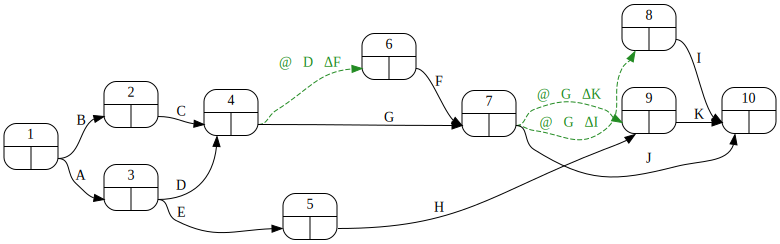

In [5]:
proyecto.pert()

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,2.0,3.0,,,,,,,,0.0
2,,,,4.0,,,,,,,2.0
3,,,,4.0,2.0,,,,,,3.0
4,,,,,,0.0,1.0,,,,7.0
5,,,,,,,,,3.0,,5.0
6,,,,,,,5.0,,,,7.0
7,,,,,,,,0.0,0.0,2.0,12.0
8,,,,,,,,,,1.0,12.0
9,,,,,,,,,,1.0,12.0
10,,,,,,,,,,,14.0


In [7]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,2,3
3,3,3
4,7,7
5,5,10
6,7,7
7,12,12
8,12,13
9,12,13
10,14,14


##### Duración media del proyecto

La duración media del proyecto es:

In [8]:
duracion_media_proyecto = proyecto.duration(datos_proyecto['duration'])
duracion_media_proyecto

14

#### Desviación de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [9]:
resultados_pert['activities'][['H_total']]

,H_total
@∇D⤑ΔF,0
@∇G⤑ΔI,1
@∇G⤑ΔK,1
A,0
B,1
C,1
D,0
E,5
F,0
G,4


##### Camino crítico

In [10]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
camino_critico

{'Route_10': ['A', 'D', '@∇D⤑ΔF', 'F', 'J']}

##### Grafo PERT con indicación del camino crítico

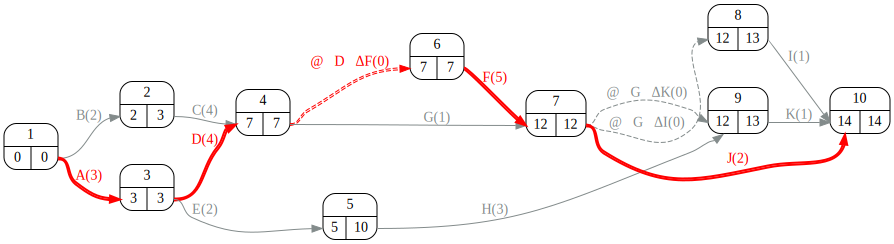

In [11]:
proyecto.pert(durations=datos_proyecto['duration'])

##### Desviación del camino crítico

A la vista del grafo PERT el camino crítico se compone de 1 rama.

El enunciado nos aporta la desviación típica, la varianza se calcula elevando al cuadrado.

In [12]:
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto.eval('standard_deviation ** 2'))
desviacion_proyecto

Variance path: Route_10 : 13
Project duration variance: 13
Project duration standard deviation: 3.605551275463989


3.605551275463989

#### Probabilidad de terminar antes de 9 periodos

In [13]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_9 = norm.cdf(9, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_9 * 100

8.275892934873497

### Apartado 2
> Indique las actuaciones a llevar a cabo para reducir la duración del proyecto hasta 10 periodos con mínimo sobrecoste.



In [14]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=4)
ackoff

D shape (11,)
Path matrix shape (13, 11)


Step: 0,	 Best option: ['J'], 	 Cost: -1, 	 Critical paths: ['Route_10']
Step: 1,	 Best option: ['D'], 	 Cost: 1, 	 Critical paths: ['Route_10', 'Route_11', 'Route_12']
Step: 2,	 Best option: ['F'], 	 Cost: 1, 	 Critical paths: ['Route_4', 'Route_5', 'Route_6', 'Route_10', 'Route_11', 'Route_12']
Step: 3,	 Best option: ['F'], 	 Cost: 1, 	 Critical paths: ['Route_4', 'Route_5', 'Route_6', 'Route_10', 'Route_11', 'Route_12']





,A,B,C,D,E,F,G,H,I,J,K,0,1,2,3,4
Route_1,,5.0,25.0,,,,-20.0,,,-1.0,,9.0,8.0,8.0,8.0,8.0
Route_2,,5.0,25.0,,,,-20.0,,5.0,,,8.0,8.0,8.0,8.0,8.0
Route_3,,5.0,25.0,,,,-20.0,,,,1.0,8.0,8.0,8.0,8.0,8.0
Route_4,,5.0,25.0,,,1.0,,,,-1.0,,13.0,12.0,12.0,11.0,10.0
Route_5,,5.0,25.0,,,1.0,,,5.0,,,12.0,12.0,12.0,11.0,10.0
Route_6,,5.0,25.0,,,1.0,,,,,1.0,12.0,12.0,12.0,11.0,10.0
Route_7,5.0,,,1.0,,,-20.0,,,-1.0,,10.0,9.0,8.0,8.0,8.0
Route_8,5.0,,,1.0,,,-20.0,,5.0,,,9.0,9.0,8.0,8.0,8.0
Route_9,5.0,,,1.0,,,-20.0,,,,1.0,9.0,9.0,8.0,8.0,8.0
Route_10,5.0,,,1.0,,1.0,,,,-1.0,,14.0,13.0,12.0,11.0,10.0


Tras esta reducción ya se ha alcanzado el objetivo de 10 periodos de duración.

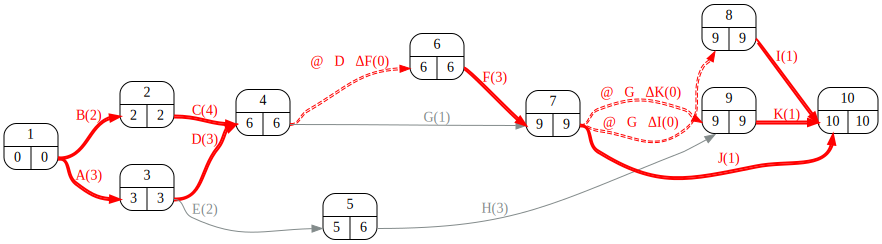

In [15]:
proyecto.pert(durations=duration)

### Apartado 3
> Nivele los recursos del proyecto.

#### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [16]:
proyecto_nivelacion = proyecto.copy()
gantt_recursos = proyecto_nivelacion.gantt_cargas(datos_proyecto, 'duration', 'resources')
gantt_recursos

Suma de cuadrados: 94 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1,1,1,,,,,,,,,,,,0.000000
B,1,1,,,,,,,,,,,,,1.000000
C,,,1,1,1,1,,,,,,,,,1.000000
D,,,,1,1,1,1,,,,,,,,0.000000
E,,,,2,2,,,,,,,,,,5.000000
F,,,,,,,,1,1,1,1,1,,,0.000000
G,,,,,,,,2,,,,,,,4.000000
H,,,,,,1,1,1,,,,,,,5.000000
I,,,,,,,,,,,,,2,,1.000000
J,,,,,,,,,,,,,1,1,0.000000


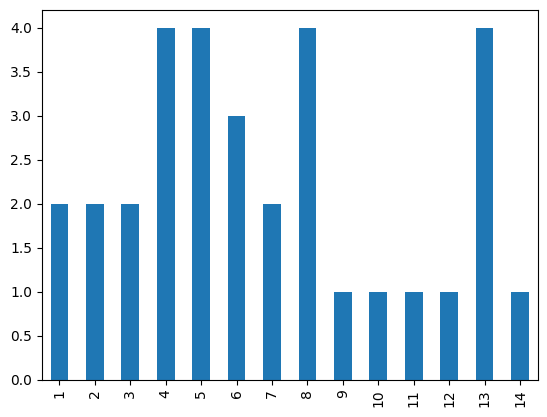

In [17]:
(gantt_recursos.data.loc['Total'].drop('H_total').plot(kind='bar'));

La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

#### Orden de desplazamientos

Se aplican las siguientes reglas:
   - Se desplazan primero aquellas no críticas aun no desplazadas con su final más temprano más próximo al principio del proyecto.
   - En caso de empate se preferirá mover primero la de mayor holgura.
   - De persistir el empate se moverá la de menor duración.
   - Descartamos del análisis las actividades f1 y f2 por no consumir recursos.
   - En caso de persistir el empate, resulta indiferente una u otra.

El orden a seguir en este caso será:

In [18]:
(proyecto_nivelacion.calendar(datos_proyecto['duration'])
   .loc[:, ['fin_mas_temprano', 'H_total', 'duracion']]
   .sort_values(by=['fin_mas_temprano', 'H_total', 'duracion'], ascending=[True, False, True])
   .query('H_total > 0')
   #.drop(['f1', 'f2'])
)

,fin_mas_temprano,H_total,duracion
activity,,,
B,2,1,2
E,5,5,2
C,6,1,4
H,8,5,3
G,8,4,1
I,13,1,1
K,13,1,1


No obstante, a medida que vayamos desplazando tareas las holguras cambiarán y algunas actividades se convertirán en críticas.

#### Desplazamientos de la actividad B

In [19]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']].copy()
suma_de_cuadrados =  proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos , 'duration', 'resources', 'B')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 94 

Desplazamiento: 1
Suma de cuadrados: 96.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,,1.000000,1.000000,,,,,,,,,,,,0.000000
C,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,2.000000,2.000000,,,,,,,,,,5.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,1.000000,1.000000,1.000000,,,,,,,5.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


,Suma_de_cuadrados
0,94
1,96


La mejor opción es no mover B.

#### Desplazamientos de la actividad E

In [20]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']].copy()
suma_de_cuadrados =  proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos, 'duration', 'resources', 'E')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 94 

Desplazamiento: 1
Suma de cuadrados: 92.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,2.000000,2.000000,,,,,,,,,4.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,1.000000,1.000000,1.000000,,,,,,4.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 88.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,,,,,,,,3.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,1.000000,1.000000,1.000000,,,,,3.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 88.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,2.000000,2.000000,,,,,,,2.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,1.000000,1.000000,1.000000,,,,2.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 4
Suma de cuadrados: 88.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,2.000000,2.000000,,,,,,1.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,,1.000000,1.000000,1.000000,,,1.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 5
Suma de cuadrados: 80.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


,Suma_de_cuadrados
0,94
1,92
2,88
3,88
4,88
5,80


La mejor opción es E: 5 con una suma de cuadrados de 80.

In [21]:
duracion_y_recursos = proyecto_nivelacion.desplazar(duracion_y_recursos , 'duration', 'resources', E=5)

Suma de cuadrados: 80.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


#### Desplazamientos de la actividad C

In [22]:
suma_de_cuadrados =  proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos , 'duration', 'resources', 'C')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 80.0 

Desplazamiento: 1
Suma de cuadrados: 80.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,0.000000
C,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


,Suma_de_cuadrados
0,80
1,80


La mejor opción es no retrasar C.

#### Desplazamientos de la actividad G

In [23]:
suma_de_cuadrados =  proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos , 'duration', 'resources', 'G')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 80.0 

Desplazamiento: 1
Suma de cuadrados: 88.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,,2.000000,,,,,,3.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 88.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,,,2.000000,,,,,2.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 84.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,,,,2.000000,,,,1.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


Desplazamiento: 4
Suma de cuadrados: 84.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,,,,,2.000000,,,0.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,2.000000,,1.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


,Suma_de_cuadrados
0,80
1,88
2,88
3,84
4,84


La mejor opción es no retrasar G.

#### Desplazamientos de la actividad I

In [24]:
suma_de_cuadrados =  proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos , 'duration', 'resources', 'I')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 80.0 

Desplazamiento: 1
Suma de cuadrados: 80.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,H_total
A,1.000000,1.000000,1.000000,,,,,,,,,,,,0.000000
B,1.000000,1.000000,,,,,,,,,,,,,1.000000
C,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,1.000000
D,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,0.000000
E,,,,,,,,,2.000000,2.000000,,,,,0.000000
F,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,,,0.000000
G,,,,,,,,2.000000,,,,,,,4.000000
H,,,,,,,,,,,1.000000,1.000000,1.000000,,0.000000
I,,,,,,,,,,,,,,2.000000,0.000000
J,,,,,,,,,,,,,1.000000,1.000000,0.000000


,Suma_de_cuadrados
0,80
1,80


La mejor opción es no retrasar I.